## **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
!pip install gradio
import gradio as gr
import torch
import gensim.downloader as api
nltk.download('stopwords')
nltk.download('wordnet')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 14.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## **Loading Dataset**

In [ ]:
df = pd.read_csv('sentiment.csv', encoding='latin-1', header=None)
df.columns = ['Sentiment', 'Text']
print(df.head())

  Sentiment                                               Text
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...


## **Handling Null Entries**

In [ ]:
print("Null values per column:\n", df.isnull().sum())
df = df.dropna()
print("Data after dropping null values:", df.shape)

Null values per column:
 Sentiment    0
Text         0
dtype: int64
Data after dropping null values: (4846, 2)


In [ ]:
df

,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


## **Text Preproccessing**

In [ ]:
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and punctuations
    text = re.sub(r'\W', ' ', text)

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Stemming
    text = ' '.join([stemmer.stem(word) for word in text.split()])

    # Lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

df['clean_text'] = df['Text'].apply(lambda x: clean_text(x))

In [ ]:
df

,Sentiment,Text,clean_text
0,neutral,"According to Gran , the company has no plans t...",accord gran compani plan move product russia a...
1,neutral,Technopolis plans to develop in stages an area...,technopoli plan develop stage area less 100 00...
2,negative,The international electronic industry company ...,intern electron industri compani elcoteq laid ...
3,positive,With the new production plant the company woul...,new product plant compani would increas capac ...
4,positive,According to the company 's updated strategy f...,accord compani updat strategi year 2009 2012 b...
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,london marketwatch share price end lower londo...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,rinkuskiai beer sale fell 6 5 per cent 4 16 mi...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,oper profit fell eur 35 4 mn eur 68 8 mn 2007 ...
4844,negative,Net sales of the Paper segment decreased to EU...,net sale paper segment decreas eur 221 6 mn se...


In [ ]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])

# Get the IDF values (inverse document frequency)
idf_values = vectorizer.idf_

# Get the words (terms) from the vectorizer
words = vectorizer.get_feature_names_out()

# Get the Document Frequency (DF) by counting how many documents contain each word
df_counts = (X > 0).sum(axis=0).A1

# Create a DataFrame with the results
result_df = pd.DataFrame({
    'word': words,
    'idf': idf_values,
    'df': df_counts
})

# Sort by IDF values
result_df = result_df.sort_values(by='idf', ascending=False)

# Print the resulting table
print(result_df)


         word       idf   df
26       0491  8.792968    1
7626  æliitto  8.792968    1
7612      zip  8.792968    1
7613    zloti  8.792968    1
7614   zoltan  8.792968    1
...       ...       ...  ...
2920  finnish  3.243892  513
5962     said  3.185329  544
4953     oper  3.178017  548
2557      eur  3.045169  626
1825  compani  2.678180  904

[7643 rows x 3 columns]


In [ ]:
df['tokens'] = df['clean_text'].apply(lambda x: x.split())

In [ ]:
df

,Sentiment,Text,clean_text,tokens
0,neutral,"According to Gran , the company has no plans t...",accord gran compani plan move product russia a...,"[accord, gran, compani, plan, move, product, r..."
1,neutral,Technopolis plans to develop in stages an area...,technopoli plan develop stage area less 100 00...,"[technopoli, plan, develop, stage, area, less,..."
2,negative,The international electronic industry company ...,intern electron industri compani elcoteq laid ...,"[intern, electron, industri, compani, elcoteq,..."
3,positive,With the new production plant the company woul...,new product plant compani would increas capac ...,"[new, product, plant, compani, would, increas,..."
4,positive,According to the company 's updated strategy f...,accord compani updat strategi year 2009 2012 b...,"[accord, compani, updat, strategi, year, 2009,..."
...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,london marketwatch share price end lower londo...,"[london, marketwatch, share, price, end, lower..."
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,rinkuskiai beer sale fell 6 5 per cent 4 16 mi...,"[rinkuskiai, beer, sale, fell, 6, 5, per, cent..."
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,oper profit fell eur 35 4 mn eur 68 8 mn 2007 ...,"[oper, profit, fell, eur, 35, 4, mn, eur, 68, ..."
4844,negative,Net sales of the Paper segment decreased to EU...,net sale paper segment decreas eur 221 6 mn se...,"[net, sale, paper, segment, decreas, eur, 221,..."


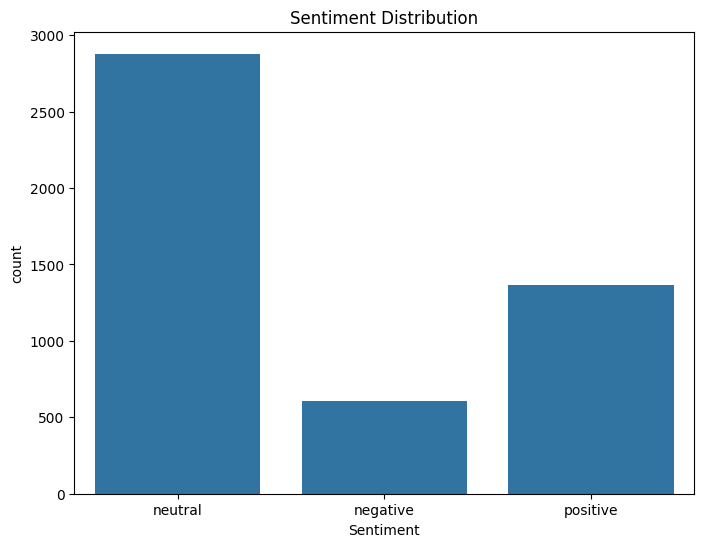

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()

In [ ]:
word_freq = defaultdict(int)
for tokens in df['tokens']:
    for token in tokens:
        word_freq[token] += 1


filtered_vocab = {word: freq for word, freq in word_freq.items() if freq >= 2}

In [ ]:
word_to_ix_filtered = {word: i for i, (word, freq) in enumerate(filtered_vocab.items())}
print("Filtered Vocabulary Size:", len(word_to_ix_filtered))

Filtered Vocabulary Size: 3867


In [ ]:
sorted_vocab = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

In [ ]:
print("Word vs Frequency (First 100 Tokens):")
for i, (word, freq) in enumerate(sorted_vocab[:100]):
    print(f"{i+1:3}. Word: {word:15} | Frequency: {freq}")

Word vs Frequency (First 100 Tokens):
  1. Word: eur             | Frequency: 1018
  2. Word: compani         | Frequency: 973
  3. Word: oper            | Frequency: 579
  4. Word: said            | Frequency: 545
  5. Word: finnish         | Frequency: 525
  6. Word: mn              | Frequency: 515
  7. Word: sale            | Frequency: 503
  8. Word: 1               | Frequency: 484
  9. Word: year            | Frequency: 449
 10. Word: share           | Frequency: 441
 11. Word: million         | Frequency: 441
 12. Word: profit          | Frequency: 432
 13. Word: net             | Frequency: 414
 14. Word: finland         | Frequency: 353
 15. Word: 2               | Frequency: 348
 16. Word: servic          | Frequency: 343
 17. Word: 5               | Frequency: 333
 18. Word: group           | Frequency: 332
 19. Word: 3               | Frequency: 327
 20. Word: product         | Frequency: 326
 21. Word: market          | Frequency: 326
 22. Word: 2009            | Frequenc

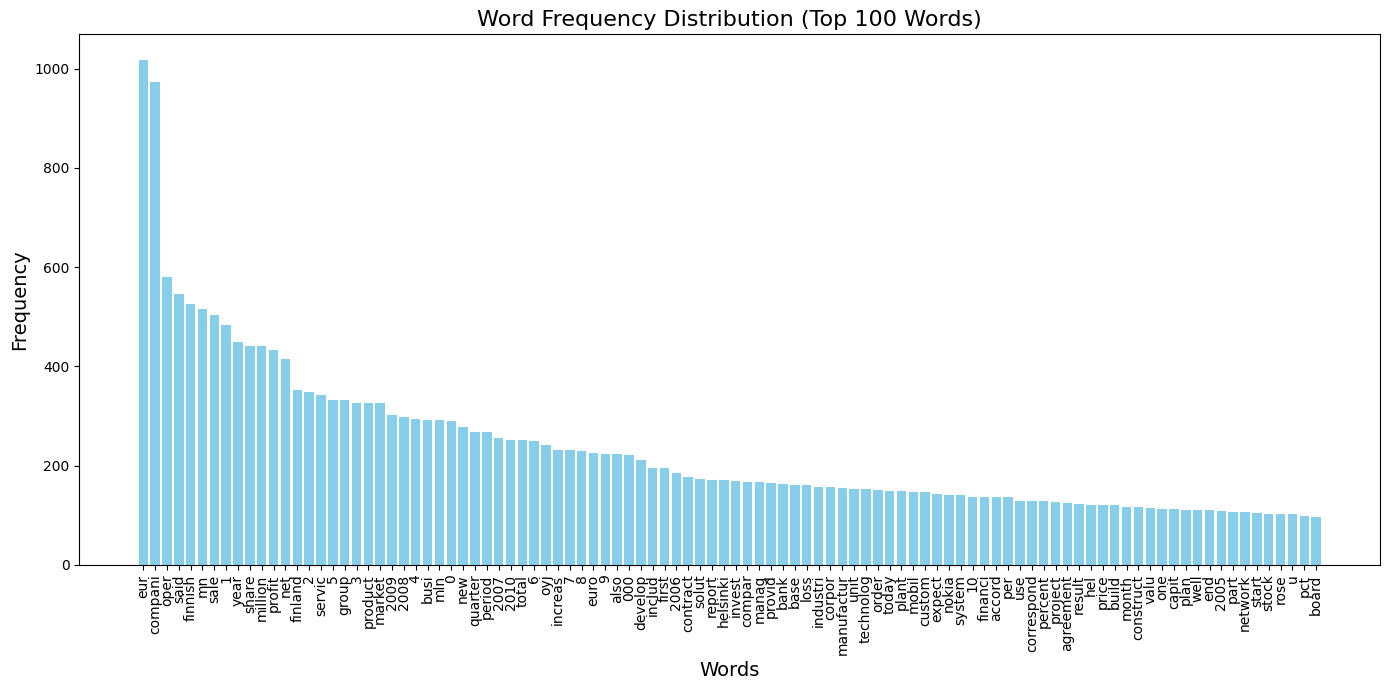

In [ ]:
top_n = 100
words = [word for word, freq in sorted_vocab[:top_n]]
frequencies = [freq for word, freq in sorted_vocab[:top_n]]
plt.figure(figsize=(14, 7))
plt.bar(words, frequencies, color='skyblue')
plt.title('Word Frequency Distribution (Top 100 Words)', fontsize=16)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()

plt.show()

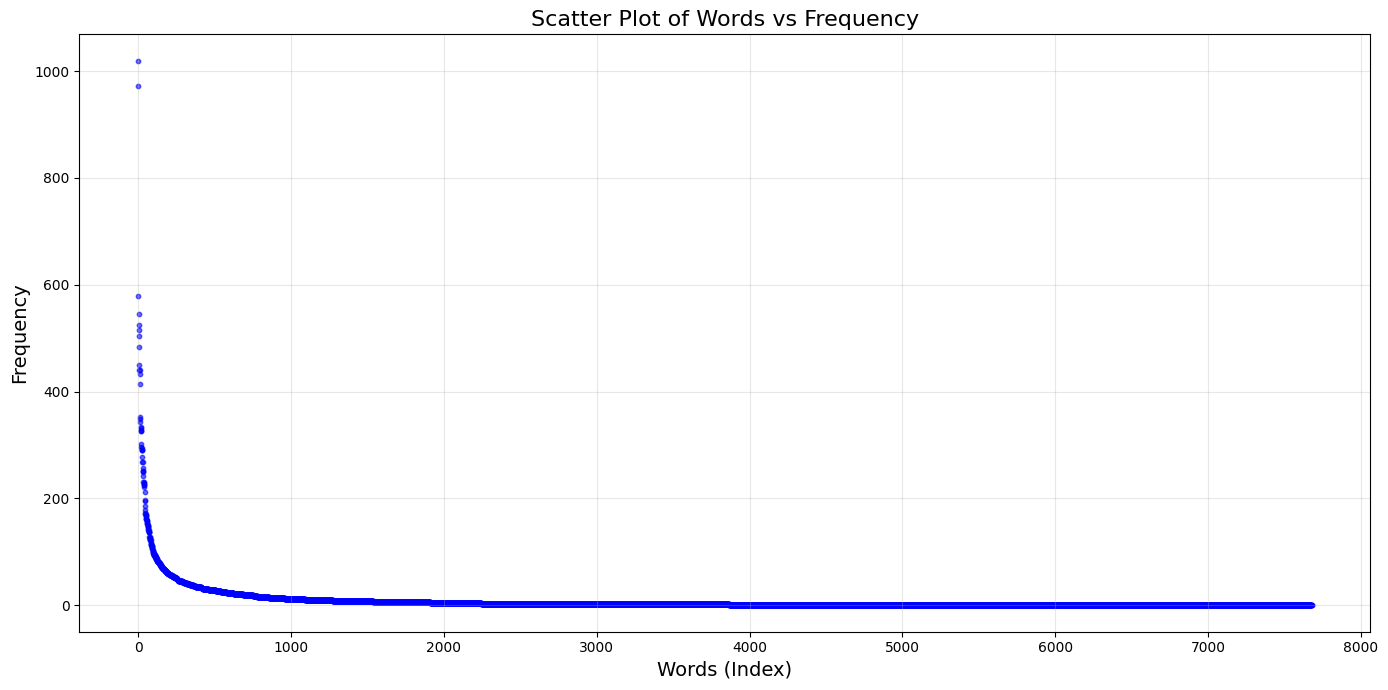

In [ ]:
words = [word for word, freq in sorted_vocab]
frequencies = [freq for word, freq in sorted_vocab]

plt.figure(figsize=(14, 7))
plt.scatter(range(len(words)), frequencies, color='blue', alpha=0.6, s=10)

plt.title('Scatter Plot of Words vs Frequency', fontsize=16)
plt.xlabel('Words (Index)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(alpha=0.3)

plt.tight_layout()

plt.show()

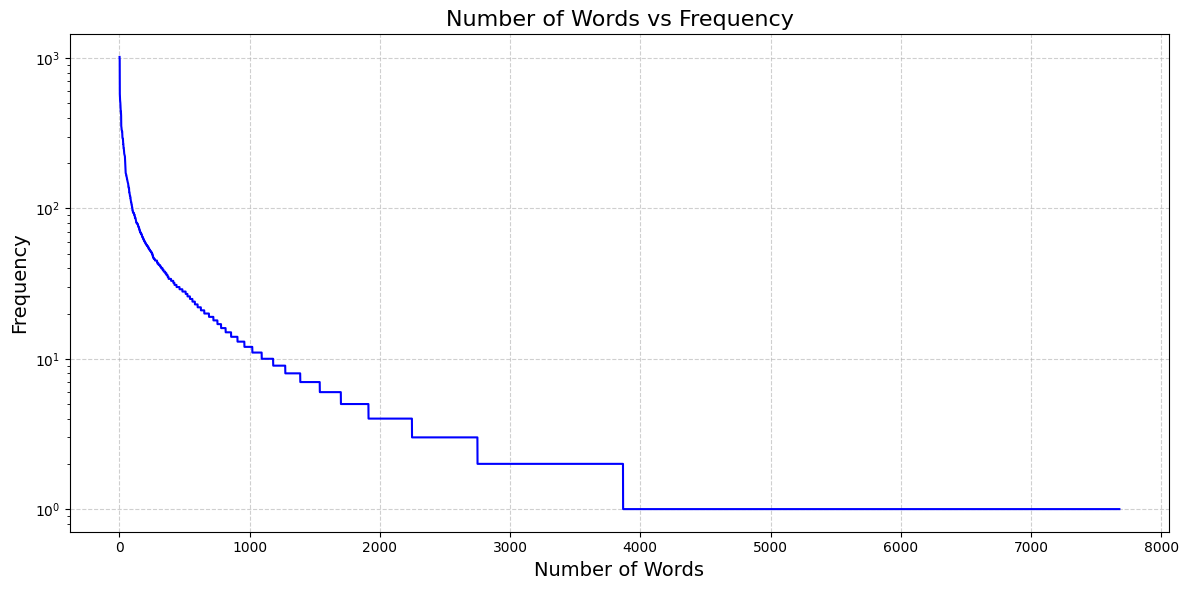

In [ ]:
all_frequencies = [freq for word, freq in sorted_vocab]

word_counts = list(range(1, len(all_frequencies) + 1))

plt.figure(figsize=(12, 6))
plt.plot(word_counts, all_frequencies, color='blue')

plt.title('Number of Words vs Frequency', fontsize=16)
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


In [ ]:
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
df['sentiment_numeric'] = df['Sentiment'].map(sentiment_mapping)

filtered_vocab_set = set(filtered_vocab.keys())

df['filtered_tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word in filtered_vocab_set])

In [ ]:
df

,Sentiment,Text,clean_text,tokens,sentiment_numeric,filtered_tokens
0,neutral,"According to Gran , the company has no plans t...",accord gran compani plan move product russia a...,"[accord, gran, compani, plan, move, product, r...",1,"[accord, gran, compani, plan, move, product, r..."
1,neutral,Technopolis plans to develop in stages an area...,technopoli plan develop stage area less 100 00...,"[technopoli, plan, develop, stage, area, less,...",1,"[technopoli, plan, develop, stage, area, less,..."
2,negative,The international electronic industry company ...,intern electron industri compani elcoteq laid ...,"[intern, electron, industri, compani, elcoteq,...",0,"[intern, electron, industri, compani, elcoteq,..."
3,positive,With the new production plant the company woul...,new product plant compani would increas capac ...,"[new, product, plant, compani, would, increas,...",2,"[new, product, plant, compani, would, increas,..."
4,positive,According to the company 's updated strategy f...,accord compani updat strategi year 2009 2012 b...,"[accord, compani, updat, strategi, year, 2009,...",2,"[accord, compani, updat, strategi, year, 2009,..."
...,...,...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,london marketwatch share price end lower londo...,"[london, marketwatch, share, price, end, lower...",0,"[london, marketwatch, share, price, end, lower..."
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,rinkuskiai beer sale fell 6 5 per cent 4 16 mi...,"[rinkuskiai, beer, sale, fell, 6, 5, per, cent...",1,"[rinkuskiai, beer, sale, fell, 6, 5, per, cent..."
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,oper profit fell eur 35 4 mn eur 68 8 mn 2007 ...,"[oper, profit, fell, eur, 35, 4, mn, eur, 68, ...",0,"[oper, profit, fell, eur, 35, 4, mn, eur, 68, ..."
4844,negative,Net sales of the Paper segment decreased to EU...,net sale paper segment decreas eur 221 6 mn se...,"[net, sale, paper, segment, decreas, eur, 221,...",0,"[net, sale, paper, segment, decreas, eur, 6, m..."


In [ ]:
from collections import defaultdict

word_freq = defaultdict(int)
for tokens in df['filtered_tokens']:
    for token in tokens:
        word_freq[token] += 1

sorted_vocab = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
word_to_ix = {word: i for i, (word, freq) in enumerate(sorted_vocab)}
vocab_size = len(word_to_ix)
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 3867


In [ ]:
def make_bow_vector(sentence, word_to_ix):
    vec = torch.zeros(len(word_to_ix))
    for word in sentence:
        if word in word_to_ix:
            vec[word_to_ix[word]] += 1
    return vec

def make_target(label):
    return torch.tensor([label], dtype=torch.long)

In [ ]:
X = df['filtered_tokens']
y = df['sentiment_numeric']

X_train_tokens, X_test_tokens, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_bow = [make_bow_vector(tokens, word_to_ix) for tokens in X_train_tokens]
X_test_bow = [make_bow_vector(tokens, word_to_ix) for tokens in X_test_tokens]

X_train_bow = torch.stack(X_train_bow)
X_test_bow = torch.stack(X_test_bow)

y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)


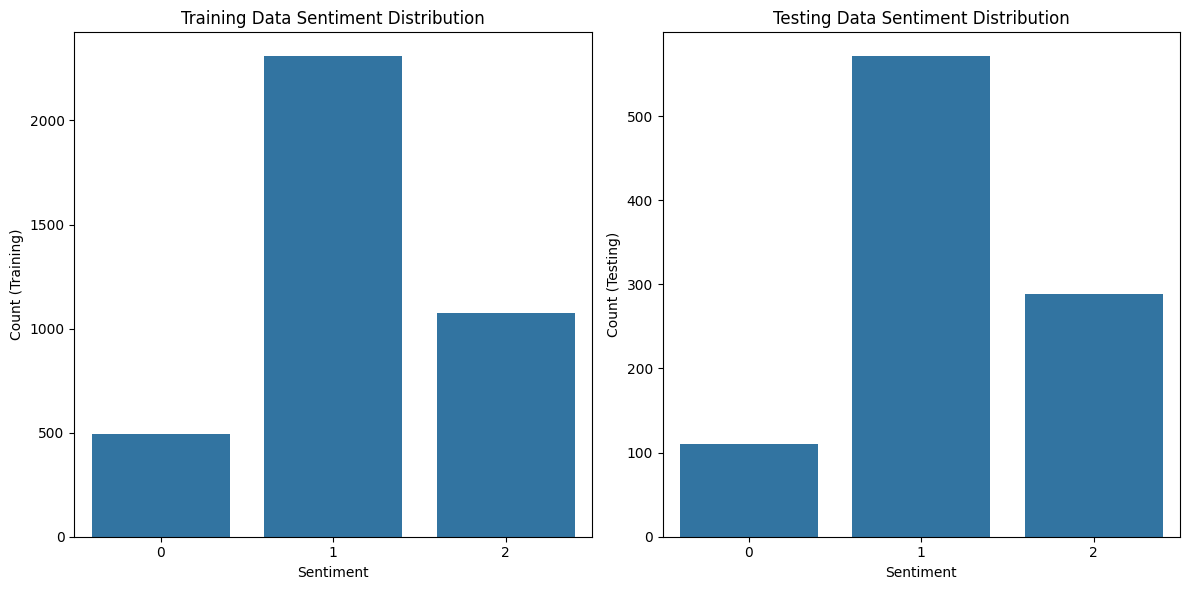

In [ ]:
train_sentiments = pd.DataFrame({'sentiment': y_train.numpy()})
test_sentiments = pd.DataFrame({'sentiment': y_test.numpy()})

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(ax=axes[0], x='sentiment', data=train_sentiments)
axes[0].set_title("Training Data Sentiment Distribution")
axes[0].set_xlabel("Sentiment")
axes[0].set_ylabel("Count (Training)")

sns.countplot(ax=axes[1], x='sentiment', data=test_sentiments)
axes[1].set_title("Testing Data Sentiment Distribution")
axes[1].set_xlabel("Sentiment")
axes[1].set_ylabel("Count (Testing)")

plt.tight_layout()
plt.show()

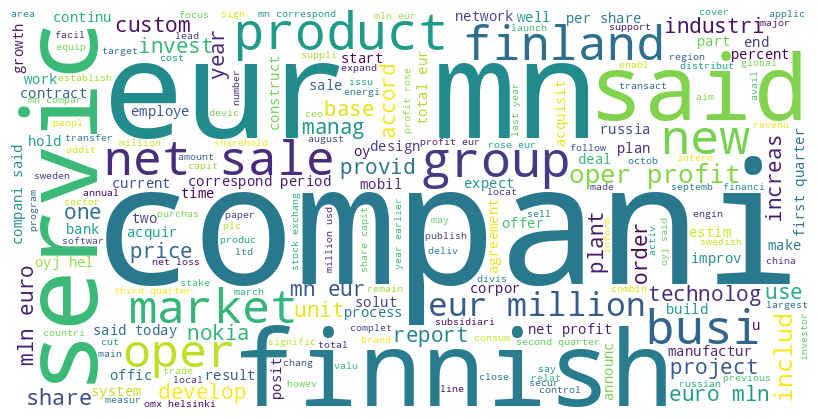

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

all_text = ' '.join(df['clean_text'].astype(str).tolist())

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=STOPWORDS,
    min_font_size=10
).generate(all_text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
print("Training Data Details:")
for i in range(len(X_train_tokens)):
    print(f"Sample {i + 1}:")
    print(f"Filtered Tokens: {X_train_tokens.iloc[i]}")
    print(f"Bag-of-Words Vector: {X_train_bow[i]}")
    print(f"Sentiment Label (Numeric): {y_train[i].item()}")
    print("="*50)

print("Test Data Details:")
for i in range(len(X_test_tokens)):
    print(f"Sample {i + 1}:")
    print(f"Filtered Tokens: {X_test_tokens.iloc[i]}")
    print(f"Bag-of-Words Vector: {X_test_bow[i]}")
    print(f"Sentiment Label (Numeric): {y_test[i].item()}")
    print("="*50)

print("\nShapes of the Tensors:")
print(f"Shape of X_train_bow: {X_train_bow.shape}")
print(f"Shape of X_test_bow: {X_test_bow.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Streaming output truncated to the last 5000 lines.
Bag-of-Words Vector: tensor([2., 0., 0.,  ..., 0., 0., 0.])
Sentiment Label (Numeric): 0
Sample 3849:
Filtered Tokens: ['l', 'ænnen', 'tehtaat', 'food', 'divis', 'reorganis', 'two', 'strateg', 'busi', 'unit', 'apetit', 'frozen', 'food', 'apetit', 'fish']
Bag-of-Words Vector: tensor([0., 0., 0.,  ..., 0., 0., 0.])
Sentiment Label (Numeric): 1
Sample 3850:
Filtered Tokens: ['huge', 'issu', 'u', 'button']
Bag-of-Words Vector: tensor([0., 0., 0.,  ..., 0., 0., 0.])
Sentiment Label (Numeric): 1
Sample 3851:
Filtered Tokens: ['equiti', 'ratio', '60', '9', 'compar', '54', '2', 'third', 'quarter', '2007', 'net', 'sale', 'frozen', 'food', 'busi', 'total', 'eur', '11', '0', '5', 'third', 'quarter', '2006']
Bag-of-Words Vector: tensor([1., 0., 0.,  ..., 0., 0., 0.])
Sentiment Label (Numeric): 2
Sample 3852:
Filtered Tokens: ['help', 'stakehold', 'get', 'better', 'understand', 'oper', 'challeng', 'stainless', 'steel', 'busi']
Bag-of-Words Vector: 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [ ]:
word2vec_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
embedding_dim = 300
embeddings = torch.zeros(vocab_size, embedding_dim)
for word, index in word_to_ix.items():
    if word in word2vec_model:
        embeddings[index] = torch.tensor(word2vec_model[word])

In [ ]:
class FFNNWithEmbeddings(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNNWithEmbeddings, self).__init__()
        self.embedding = nn.Embedding(input_dim, 300)  # Embedding layer
        self.embedding.weight.data.copy_(embeddings)
        self.embedding.weight.requires_grad = False  # Freeze embeddings
        self.fc1 = nn.Linear(300, hidden_dim)  # Hidden layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # Output layer

    def forward(self, x):
        # Cast the input to LongTensor
        x = x.type(torch.LongTensor).to(device)

        # Get embeddings for each word in the input
        embedded = self.embedding(x)

        # Average embeddings to get a single vector for the sequence
        embedded = torch.mean(embedded, dim=1) # <--- Changed here

        x = torch.relu(self.fc1(embedded))  # Apply ReLU activation
        x = self.fc2(x)  # Output layer
        return x

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# Define constants
input_dim = vocab_size
hidden_dim = 256
output_dim = 3
patience = 10  # Stop training if no improvement after 10 epochs
min_delta = 1e-3  # Minimum change in loss to qualify as an improvement
learning_rate = 1e-2

# Instantiate the 1-layer model
ff_nn_model_1layer = FFNNWithEmbeddings(input_dim, hidden_dim, output_dim).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ff_nn_model_1layer.parameters(), lr=learning_rate)

# Prepare DataLoader
train_dataset = TensorDataset(X_train_bow, y_train)
train_loader = DataLoader(dataset=train_dataset, shuffle=True)

# Training loop for 1-layer model
best_loss = float('inf')
epochs_without_improvement = 0
epoch = 0
ffnn_losses_1layer = []

while True:
    epoch += 1
    total_loss = 0
    ff_nn_model_1layer.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = ff_nn_model_1layer(data)

        # Reshape outputs for CrossEntropyLoss
        outputs = outputs.view(-1, outputs.shape[-1])

        # Compute loss
        loss = criterion(outputs, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    ffnn_losses_1layer.append(avg_loss)

    print(f'Epoch [{epoch}], Loss: {avg_loss:.4f}')

    # Early stopping check
    if avg_loss < best_loss - min_delta:
        best_loss = avg_loss
        epochs_without_improvement = 0  # Reset the patience counter
    else:
        epochs_without_improvement += 1

    # Stop training if no improvement for patience epochs
    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch} with best loss {best_loss:.4f}')
        break

Epoch [1], Loss: 0.9387
Epoch [2], Loss: 0.9341
Epoch [3], Loss: 0.9310
Epoch [4], Loss: 0.9291
Epoch [5], Loss: 0.9285
Epoch [6], Loss: 0.9287
Epoch [7], Loss: 0.9288
Epoch [8], Loss: 0.9287
Epoch [9], Loss: 0.9287
Epoch [10], Loss: 0.9287
Epoch [11], Loss: 0.9281
Epoch [12], Loss: 0.9292
Epoch [13], Loss: 0.9283
Epoch [14], Loss: 0.9281
Epoch [15], Loss: 0.9287
Epoch [16], Loss: 0.9287
Epoch [17], Loss: 0.9279
Epoch [18], Loss: 0.9282
Epoch [19], Loss: 0.9290
Epoch [20], Loss: 0.9287
Epoch [21], Loss: 0.9288
Early stopping at epoch 21 with best loss 0.9281


FFNN Accuracy: 0.5887
FFNN Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       110
     Neutral       0.59      1.00      0.74       571
    Positive       0.00      0.00      0.00       289

    accuracy                           0.59       970
   macro avg       0.20      0.33      0.25       970
weighted avg       0.35      0.59      0.44       970



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


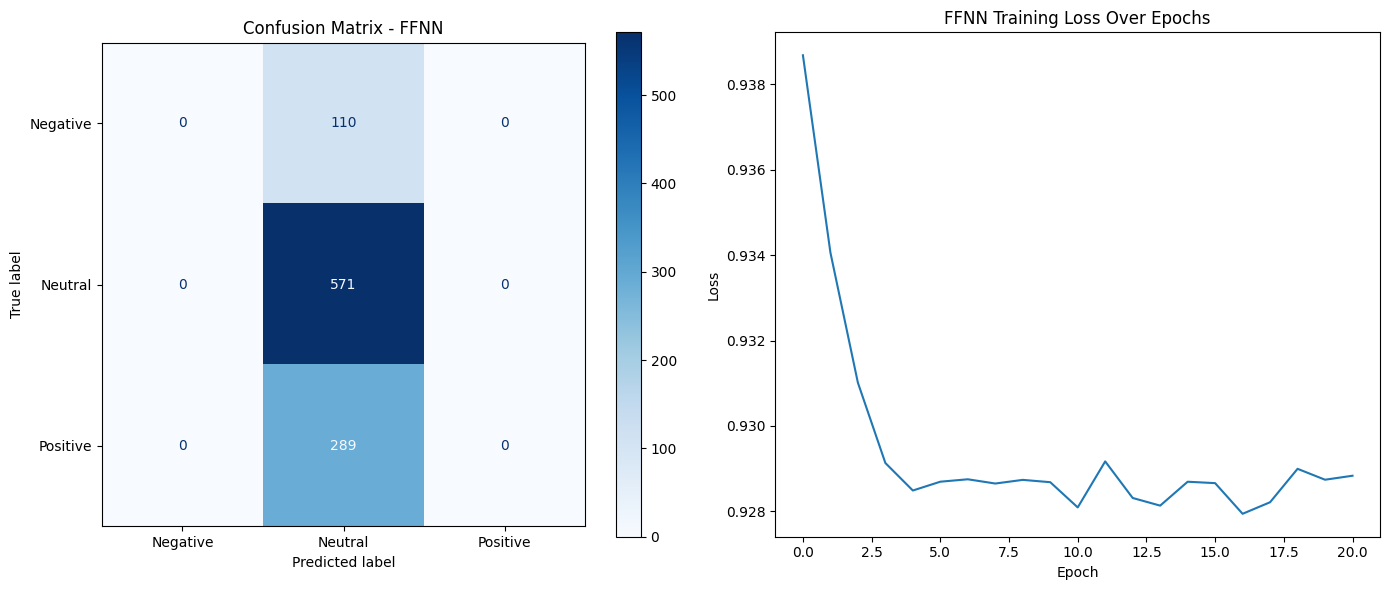

In [ ]:
# FFNN Evaluation: Test set predictions and metrics
ff_nn_model_1layer.eval()  # Set the model to evaluation mode
ffnn_predictions = []
actual_labels = []

with torch.no_grad():
    for i in range(len(X_test_bow)):
        bow_vector = X_test_bow[i].to(device)  # Move to GPU if available

        # Add an extra dimension to the input
        bow_vector = bow_vector.unsqueeze(0)  # Shape: (1, input_dim)

        output = ff_nn_model_1layer(bow_vector)

        # Get the predicted label
        predicted_label = torch.argmax(output, dim=1).item()
        ffnn_predictions.append(predicted_label)
        actual_labels.append(y_test[i].item())

# Accuracy, classification report, and confusion matrix
accuracy = accuracy_score(actual_labels, ffnn_predictions)
print(f"FFNN Accuracy: {accuracy:.4f}")

print("FFNN Classification Report:")
print(classification_report(actual_labels, ffnn_predictions, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
cm = confusion_matrix(actual_labels, ffnn_predictions)

# Create subplots for confusion matrix and loss plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title("Confusion Matrix - FFNN")

# Loss over epochs plot
axes[1].plot(ffnn_losses_1layer) # Changed ffnn_losses to ffnn_losses_1layer
axes[1].set_title('FFNN Training Loss Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
!pip install scikit-learn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV

class PyTorchClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=1e-2):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.model = FFNNWithEmbeddings(input_dim, hidden_dim, output_dim).to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate)

    def fit(self, X, y):
        # Convert data to PyTorch tensors
        X = torch.tensor(X, dtype=torch.float32).to(device)
        y = torch.tensor(y, dtype=torch.long).to(device)

        # Training loop
        for epoch in range(100):  # Example: Train for 100 epochs
            self.model.train()
            self.optimizer.zero_grad()
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            loss.backward()
            self.optimizer.step()

        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X = torch.tensor(X, dtype=torch.float32).to(device)
            outputs = self.model(X)
            predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()
        return predicted_labels

# Now use the wrapper with GridSearchCV
param_grid = {
    'hidden_dim': [128, 256, 512],
    'learning_rate': [1e-2, 1e-3, 1e-4],
}
grid_search = GridSearchCV(
    estimator=PyTorchClassifierWrapper(vocab_size, 128, 3),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
)
grid_search.fit(X_train_bow.cpu().numpy(), y_train.cpu().numpy())
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 199, in _get_response_values
    classes = estimator.classe

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.75 GiB. GPU 0 has a total capacity of 14.75 GiB of which 1.04 GiB is free. Process 12212 has 13.70 GiB memory in use. Of the allocated memory 233.27 MiB is allocated by PyTorch, and 13.34 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:

# Define a 1-layer feedforward neural network model
class FeedforwardNeuralNetModel_1Layer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel_1Layer, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # Input to hidden layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # Hidden to output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation after the first layer
        x = self.fc2(x)  # Output layer
        return x

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# Define constants
input_dim = vocab_size
hidden_dim = 256
output_dim = 3
patience = 10  # Stop training if no improvement after 10 epochs
min_delta = 1e-3  # Minimum change in loss to qualify as an improvement
learning_rate = 1e-1

# Instantiate the 1-layer model
ff_nn_model_1layer = FeedforwardNeuralNetModel_1Layer(input_dim, hidden_dim, output_dim).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ff_nn_model_1layer.parameters(), lr=learning_rate)

# Prepare DataLoader
train_dataset = TensorDataset(X_train_bow, y_train)
train_loader = DataLoader(dataset=train_dataset, shuffle=True)

# Training loop for 1-layer model
best_loss = float('inf')
epochs_without_improvement = 0
epoch = 0
ffnn_losses_1layer = []

while True:
    epoch += 1
    total_loss = 0
    ff_nn_model_1layer.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = ff_nn_model_1layer(data)

        # Compute loss
        loss = criterion(outputs, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    ffnn_losses_1layer.append(avg_loss)

    print(f'Epoch [{epoch}], Loss: {avg_loss:.4f}')

    # Early stopping check
    if avg_loss < best_loss - min_delta:
        best_loss = avg_loss
        epochs_without_improvement = 0  # Reset the patience counter
    else:
        epochs_without_improvement += 1

    # Stop training if no improvement for patience epochs
    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch} with best loss {best_loss:.4f}')
        break

Epoch [1], Loss: 0.7779
Epoch [2], Loss: 0.5429
Epoch [3], Loss: 0.3294
Epoch [4], Loss: 0.2014
Epoch [5], Loss: 0.1608
Epoch [6], Loss: 0.0829
Epoch [7], Loss: 0.0524
Epoch [8], Loss: 0.0339
Epoch [9], Loss: 0.0221
Epoch [10], Loss: 0.0354
Epoch [11], Loss: 0.0223
Epoch [12], Loss: 0.0087
Epoch [13], Loss: 0.0050
Epoch [14], Loss: 0.0047
Epoch [15], Loss: 0.0037
Epoch [16], Loss: 0.0027
Epoch [17], Loss: 0.0031
Epoch [18], Loss: 0.0029
Epoch [19], Loss: 0.0030
Epoch [20], Loss: 0.0025
Epoch [21], Loss: 0.0024
Epoch [22], Loss: 0.0022
Epoch [23], Loss: 0.0021
Epoch [24], Loss: 0.0022
Epoch [25], Loss: 0.0020
Epoch [26], Loss: 0.0021
Epoch [27], Loss: 0.0019
Epoch [28], Loss: 0.0017
Epoch [29], Loss: 0.0015
Epoch [30], Loss: 0.0022
Early stopping at epoch 30 with best loss 0.0025


FFNN Accuracy: 0.7412
FFNN Classification Report:
              precision    recall  f1-score   support

    Negative       0.62      0.55      0.59       110
     Neutral       0.79      0.87      0.82       571
    Positive       0.67      0.56      0.61       289

    accuracy                           0.74       970
   macro avg       0.69      0.66      0.67       970
weighted avg       0.73      0.74      0.73       970



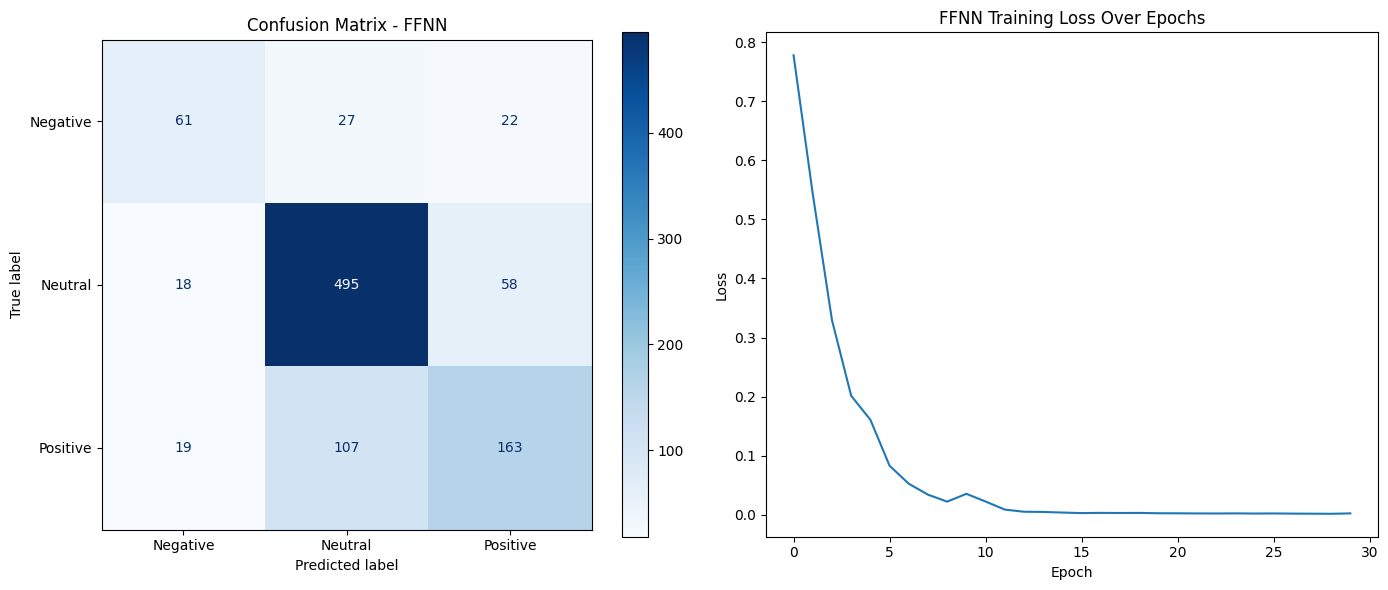

In [ ]:
# FFNN Evaluation: Test set predictions and metrics
ff_nn_model_1layer.eval()  # Set the model to evaluation mode
ffnn_predictions = []
actual_labels = []

with torch.no_grad():
    for i in range(len(X_test_bow)):
        bow_vector = X_test_bow[i].to(device)  # Move to GPU if available

        # Add an extra dimension to the input
        bow_vector = bow_vector.unsqueeze(0)  # Shape: (1, input_dim)

        output = ff_nn_model_1layer(bow_vector)

        # Get the predicted label
        predicted_label = torch.argmax(output, dim=1).item()
        ffnn_predictions.append(predicted_label)
        actual_labels.append(y_test[i].item())

# Accuracy, classification report, and confusion matrix
accuracy = accuracy_score(actual_labels, ffnn_predictions)
print(f"FFNN Accuracy: {accuracy:.4f}")

print("FFNN Classification Report:")
print(classification_report(actual_labels, ffnn_predictions, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
cm = confusion_matrix(actual_labels, ffnn_predictions)

# Create subplots for confusion matrix and loss plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title("Confusion Matrix - FFNN")

# Loss over epochs plot
axes[1].plot(ffnn_losses_1layer) # Changed ffnn_losses to ffnn_losses_1layer
axes[1].set_title('FFNN Training Loss Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
class FeedforwardNeuralNetModel_2Layer(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(FeedforwardNeuralNetModel_2Layer, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)  # Input to first hidden layer
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)  # First hidden to second hidden layer
        self.fc3 = nn.Linear(hidden_dim2, output_dim)  # Second hidden to output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU activation for the first hidden layer
        x = torch.relu(self.fc2(x))  # ReLU activation for the second hidden layer
        x = self.fc3(x)  # Output layer
        return x

In [ ]:
# Define constants
input_dim = vocab_size
hidden_dim1 = 512
hidden_dim2 = 512  # Add another hidden layer dimension
output_dim = 3
patience = 10  # Stop training if no improvement after 10 epochs
min_delta = 1e-3  # Minimum change in loss to qualify as an improvement
learning_rate = 1e-2

# Instantiate the 2-layer model
ff_nn_model_2layer = FeedforwardNeuralNetModel_2Layer(input_dim, hidden_dim1, hidden_dim2, output_dim).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ff_nn_model_2layer.parameters(), lr=learning_rate)

# Prepare DataLoader
train_dataset = TensorDataset(X_train_bow, y_train)
train_loader = DataLoader(dataset=train_dataset, shuffle=True)

# Training loop for 2-layer model
best_loss = float('inf')
epochs_without_improvement = 0
epoch = 0
ffnn_losses_2layer = []

while True:
    epoch += 1
    total_loss = 0
    ff_nn_model_2layer.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = ff_nn_model_2layer(data)

        # Compute loss
        loss = criterion(outputs, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    ffnn_losses_2layer.append(avg_loss)

    print(f'Epoch [{epoch}], Loss: {avg_loss:.4f}')

    # Early stopping check
    if avg_loss < best_loss - min_delta:
        best_loss = avg_loss
        epochs_without_improvement = 0  # Reset the patience counter
    else:
        epochs_without_improvement += 1

    # Stop training if no improvement for patience epochs
    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch} with best loss {best_loss:.4f}')
        break

Epoch [1], Loss: 0.8701
Epoch [2], Loss: 0.6989
Epoch [3], Loss: 0.5104
Epoch [4], Loss: 0.3402
Epoch [5], Loss: 0.2163
Epoch [6], Loss: 0.1336
Epoch [7], Loss: 0.0848
Epoch [8], Loss: 0.0548
Epoch [9], Loss: 0.0334
Epoch [10], Loss: 0.0190
Epoch [11], Loss: 0.0191
Epoch [12], Loss: 0.0132
Epoch [13], Loss: 0.0127
Epoch [14], Loss: 0.0107
Epoch [15], Loss: 0.0077
Epoch [16], Loss: 0.0055
Epoch [17], Loss: 0.0060
Epoch [18], Loss: 0.0036
Epoch [19], Loss: 0.0045
Epoch [20], Loss: 0.0027
Epoch [21], Loss: 0.0028
Epoch [22], Loss: 0.0026
Epoch [23], Loss: 0.0032
Epoch [24], Loss: 0.0027
Epoch [25], Loss: 0.0023
Epoch [26], Loss: 0.0022
Epoch [27], Loss: 0.0021
Epoch [28], Loss: 0.0024
Epoch [29], Loss: 0.0021
Epoch [30], Loss: 0.0021
Epoch [31], Loss: 0.0022
Epoch [32], Loss: 0.0020
Epoch [33], Loss: 0.0019
Epoch [34], Loss: 0.0017
Epoch [35], Loss: 0.0020
Early stopping at epoch 35 with best loss 0.0023


FFNN Accuracy: 0.7423
FFNN Classification Report:
              precision    recall  f1-score   support

    Negative       0.66      0.59      0.62       110
     Neutral       0.78      0.86      0.82       571
    Positive       0.68      0.57      0.62       289

    accuracy                           0.74       970
   macro avg       0.71      0.67      0.69       970
weighted avg       0.74      0.74      0.74       970



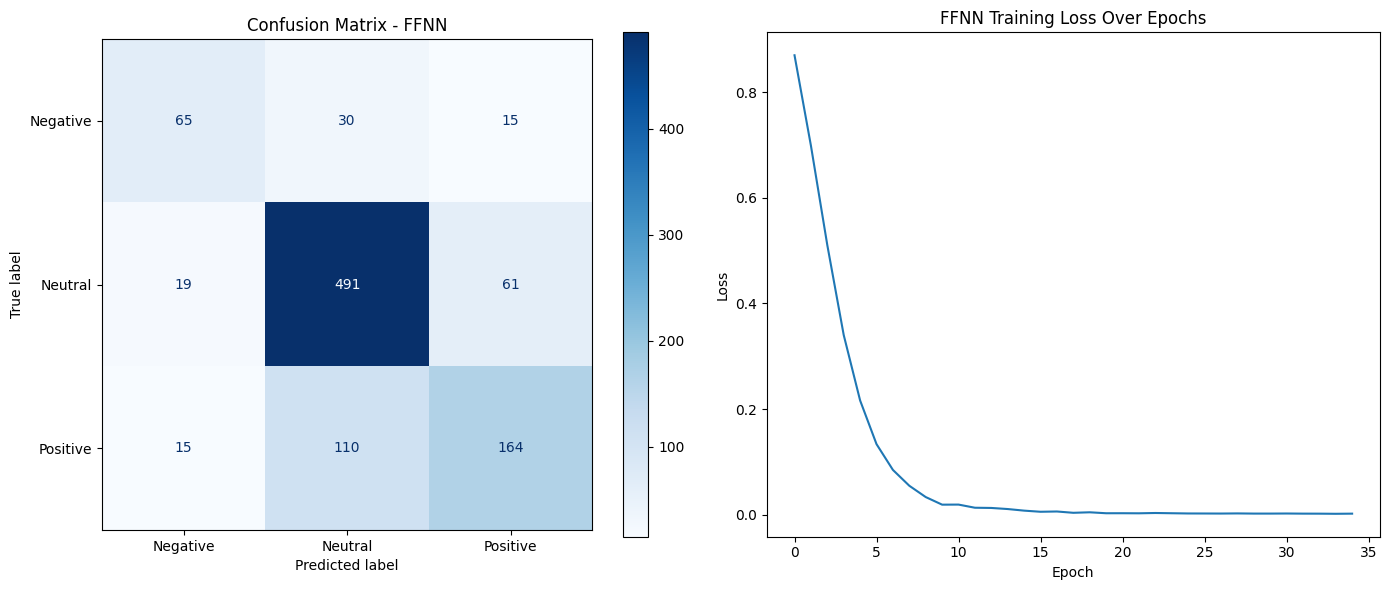

In [ ]:

# FFNN Evaluation: Test set predictions and metrics
ff_nn_model_2layer.eval()  # Set the model to evaluation mode
ffnn_predictions = []
actual_labels = []

with torch.no_grad():
    for i in range(len(X_test_bow)):
        bow_vector = X_test_bow[i].to(device)  # Move to GPU if available

        # Add an extra dimension to the input
        bow_vector = bow_vector.unsqueeze(0)  # Shape: (1, input_dim)

        output = ff_nn_model_2layer(bow_vector)

        # Get the predicted label
        predicted_label = torch.argmax(output, dim=1).item()
        ffnn_predictions.append(predicted_label)
        actual_labels.append(y_test[i].item())

# Accuracy, classification report, and confusion matrix
accuracy = accuracy_score(actual_labels, ffnn_predictions)
print(f"FFNN Accuracy: {accuracy:.4f}")

print("FFNN Classification Report:")
print(classification_report(actual_labels, ffnn_predictions, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
cm = confusion_matrix(actual_labels, ffnn_predictions)

# Create subplots for confusion matrix and loss plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title("Confusion Matrix - FFNN")

# Loss over epochs plot
axes[1].plot(ffnn_losses_2layer)  # Plot the 2-layer model losses
axes[1].set_title('FFNN Training Loss Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
class FeedforwardNeuralNetModel_3Layer(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(FeedforwardNeuralNetModel_3Layer, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)  # Input to first hidden layer
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)  # First hidden to second hidden layer
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)  # Second hidden to third hidden layer
        self.fc4 = nn.Linear(hidden_dim3, output_dim)  # Third hidden to output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU activation for the first hidden layer
        x = torch.relu(self.fc2(x))  # ReLU activation for the second hidden layer
        x = torch.relu(self.fc3(x))  # ReLU activation for the third hidden layer
        x = self.fc4(x)  # Output layer
        return x

In [ ]:

# Define constants
input_dim = vocab_size
hidden_dim1 = 512
hidden_dim2 = 256
hidden_dim3 = 128  # Add another hidden layer dimension
output_dim = 3
patience = 10  # Stop training if no improvement after 10 epochs
min_delta = 1e-3  # Minimum change in loss to qualify as an improvement
learning_rate = 1e-2

# Instantiate the 3-layer model
ff_nn_model_3layer = FeedforwardNeuralNetModel_3Layer(
    input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim
).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ff_nn_model_3layer.parameters(), lr=learning_rate)

# Prepare DataLoader
train_dataset = TensorDataset(X_train_bow, y_train)
train_loader = DataLoader(dataset=train_dataset, shuffle=True)

# Training loop for 3-layer model
best_loss = float("inf")
epochs_without_improvement = 0
epoch = 0
ffnn_losses_3layer = []

while True:
    epoch += 1
    total_loss = 0
    ff_nn_model_3layer.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = ff_nn_model_3layer(data)

        # Compute loss
        loss = criterion(outputs, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    ffnn_losses_3layer.append(avg_loss)

    print(f"Epoch [{epoch}], Loss: {avg_loss:.4f}")

    # Early stopping check
    if avg_loss < best_loss - min_delta:
        best_loss = avg_loss
        epochs_without_improvement = 0  # Reset the patience counter
    else:
        epochs_without_improvement += 1

    # Stop training if no improvement for patience epochs
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch} with best loss {best_loss:.4f}")
        break

Epoch [1], Loss: 0.9100
Epoch [2], Loss: 0.7600
Epoch [3], Loss: 0.6168
Epoch [4], Loss: 0.5035
Epoch [5], Loss: 0.3662
Epoch [6], Loss: 0.2418
Epoch [7], Loss: 0.1531
Epoch [8], Loss: 0.0951
Epoch [9], Loss: 0.0654
Epoch [10], Loss: 0.0533
Epoch [11], Loss: 0.0355
Epoch [12], Loss: 0.0159
Epoch [13], Loss: 0.0163
Epoch [14], Loss: 0.0162
Epoch [15], Loss: 0.0121
Epoch [16], Loss: 0.0099
Epoch [17], Loss: 0.0047
Epoch [18], Loss: 0.0029
Epoch [19], Loss: 0.0025
Epoch [20], Loss: 0.0015
Epoch [21], Loss: 0.0045
Epoch [22], Loss: 0.0035
Epoch [23], Loss: 0.0025
Epoch [24], Loss: 0.0023
Epoch [25], Loss: 0.0018
Epoch [26], Loss: 0.0019
Epoch [27], Loss: 0.0018
Epoch [28], Loss: 0.0019
Epoch [29], Loss: 0.0017
Epoch [30], Loss: 0.0020
Early stopping at epoch 30 with best loss 0.0015


FFNN Accuracy: 0.7412
FFNN Classification Report:
              precision    recall  f1-score   support

    Negative       0.66      0.59      0.62       110
     Neutral       0.78      0.85      0.82       571
    Positive       0.67      0.58      0.62       289

    accuracy                           0.74       970
   macro avg       0.70      0.67      0.69       970
weighted avg       0.74      0.74      0.74       970



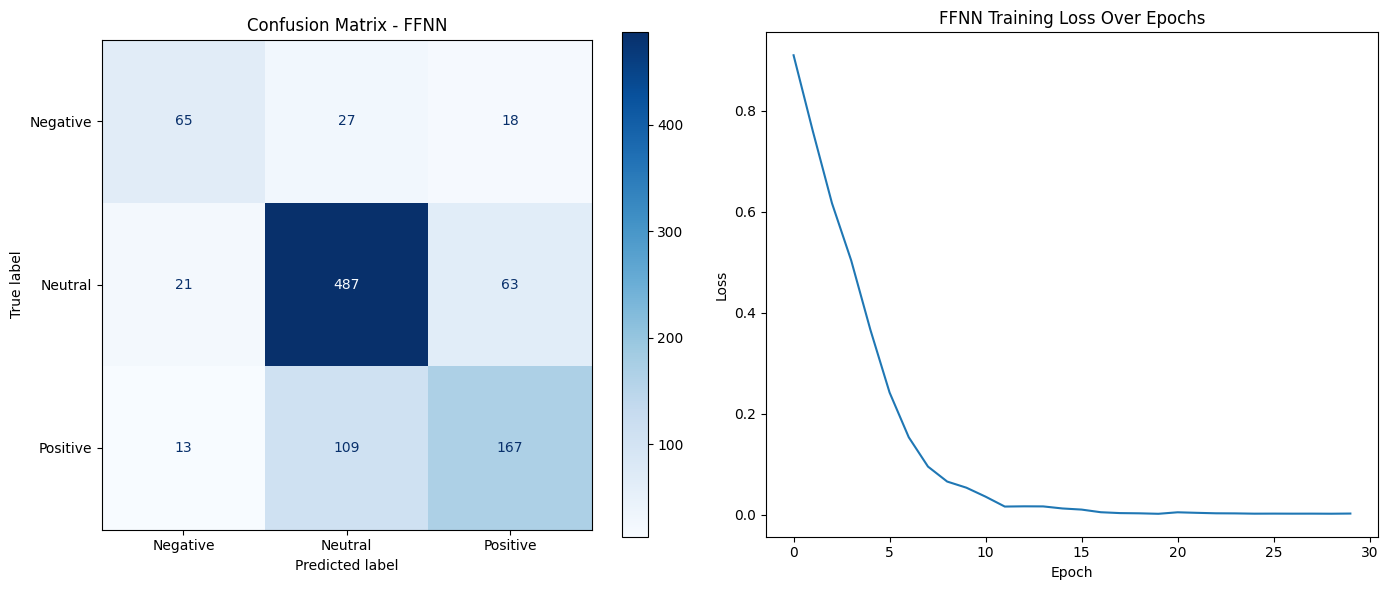

In [ ]:
# FFNN Evaluation: Test set predictions and metrics
ff_nn_model_3layer.eval()  # Set the model to evaluation mode
ffnn_predictions = []
actual_labels = []

with torch.no_grad():
    for i in range(len(X_test_bow)):
        bow_vector = X_test_bow[i].to(device)  # Move to GPU if available

        # Add an extra dimension to the input
        bow_vector = bow_vector.unsqueeze(0)  # Shape: (1, input_dim)

        output = ff_nn_model_3layer(bow_vector)

        # Get the predicted label
        predicted_label = torch.argmax(output, dim=1).item()
        ffnn_predictions.append(predicted_label)
        actual_labels.append(y_test[i].item())

# Accuracy, classification report, and confusion matrix
accuracy = accuracy_score(actual_labels, ffnn_predictions)
print(f"FFNN Accuracy: {accuracy:.4f}")

print("FFNN Classification Report:")
print(classification_report(actual_labels, ffnn_predictions, target_names=["Negative", "Neutral", "Positive"]))

# Confusion matrix
cm = confusion_matrix(actual_labels, ffnn_predictions)

# Create subplots for confusion matrix and loss plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title("Confusion Matrix - FFNN")

# Loss over epochs plot
axes[1].plot(ffnn_losses_3layer)  # Plot the 3-layer model losses
axes[1].set_title("FFNN Training Loss Over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
class FeedforwardNeuralNetModel_4Layer(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim):
        super(FeedforwardNeuralNetModel_4Layer, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)  # Input to first hidden layer
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)  # First hidden to second hidden layer
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)  # Second hidden to third hidden layer
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)  # Third hidden to fourth hidden layer
        self.fc5 = nn.Linear(hidden_dim4, output_dim)  # Fourth hidden to output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU activation for the first hidden layer
        x = torch.relu(self.fc2(x))  # ReLU activation for the second hidden layer
        x = torch.relu(self.fc3(x))  # ReLU activation for the third hidden layer
        x = torch.relu(self.fc4(x))  # ReLU activation for the fourth hidden layer
        x = self.fc5(x)  # Output layer
        return x

In [ ]:


# Define constants
input_dim = vocab_size  # Set your vocab size here
hidden_dim1 = 512
hidden_dim2 = 256
hidden_dim3 = 128  # Dimensions for the third hidden layer
hidden_dim4 = 64   # Dimensions for the fourth hidden layer
output_dim = 3
patience = 10  # Stop training if no improvement after 10 epochs
min_delta = 1e-3  # Minimum change in loss to qualify as an improvement
learning_rate = 1e-2

# Instantiate the 4-layer model
ff_nn_model_4layer = FeedforwardNeuralNetModel_4Layer(
    input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim
).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ff_nn_model_4layer.parameters(), lr=learning_rate)

# Prepare DataLoader
train_dataset = TensorDataset(X_train_bow, y_train)
train_loader = DataLoader(dataset=train_dataset, shuffle=True)

# Training loop for 4-layer model
best_loss = float("inf")
epochs_without_improvement = 0
epoch = 0
ffnn_losses_4layer = []

while True:
    epoch += 1
    total_loss = 0
    ff_nn_model_4layer.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = ff_nn_model_4layer(data)

        # Compute loss
        loss = criterion(outputs, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    ffnn_losses_4layer.append(avg_loss)

    print(f"Epoch [{epoch}], Loss: {avg_loss:.4f}")

    # Early stopping check
    if avg_loss < best_loss - min_delta:
        best_loss = avg_loss
        epochs_without_improvement = 0  # Reset the patience counter
    else:
        epochs_without_improvement += 1

    # Stop training if no improvement for 'patience' epochs
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch} with best loss {best_loss:.4f}")
        break


Epoch [1], Loss: 0.9351
Epoch [2], Loss: 0.9020
Epoch [3], Loss: 0.7597
Epoch [4], Loss: 0.6256
Epoch [5], Loss: 0.5165
Epoch [6], Loss: 0.4153
Epoch [7], Loss: 0.3501
Epoch [8], Loss: 0.3003
Epoch [9], Loss: 0.2453
Epoch [10], Loss: 0.1855
Epoch [11], Loss: 0.1440
Epoch [12], Loss: 0.0934
Epoch [13], Loss: 0.0577
Epoch [14], Loss: 0.0421
Epoch [15], Loss: 0.0266
Epoch [16], Loss: 0.0235
Epoch [17], Loss: 0.0264
Epoch [18], Loss: 0.0264
Epoch [19], Loss: 0.0222
Epoch [20], Loss: 0.0127
Epoch [21], Loss: 0.0134
Epoch [22], Loss: 0.0242
Epoch [23], Loss: 0.0119
Epoch [24], Loss: 0.0234
Epoch [25], Loss: 0.0280
Epoch [26], Loss: 0.0161
Epoch [27], Loss: 0.0069
Epoch [28], Loss: 0.0089
Epoch [29], Loss: 0.0046
Epoch [30], Loss: 0.0136
Epoch [31], Loss: 0.0181
Epoch [32], Loss: 0.0037
Epoch [33], Loss: 0.0029
Epoch [34], Loss: 0.0016
Epoch [35], Loss: 0.0019
Epoch [36], Loss: 0.0014
Epoch [37], Loss: 0.0015
Epoch [38], Loss: 0.0015
Epoch [39], Loss: 0.0013
Epoch [40], Loss: 0.0015
Epoch [41

FFNN Accuracy: 0.7206
FFNN Classification Report:
              precision    recall  f1-score   support

    Negative       0.66      0.54      0.59       110
     Neutral       0.76      0.84      0.80       571
    Positive       0.63      0.55      0.59       289

    accuracy                           0.72       970
   macro avg       0.69      0.64      0.66       970
weighted avg       0.71      0.72      0.71       970



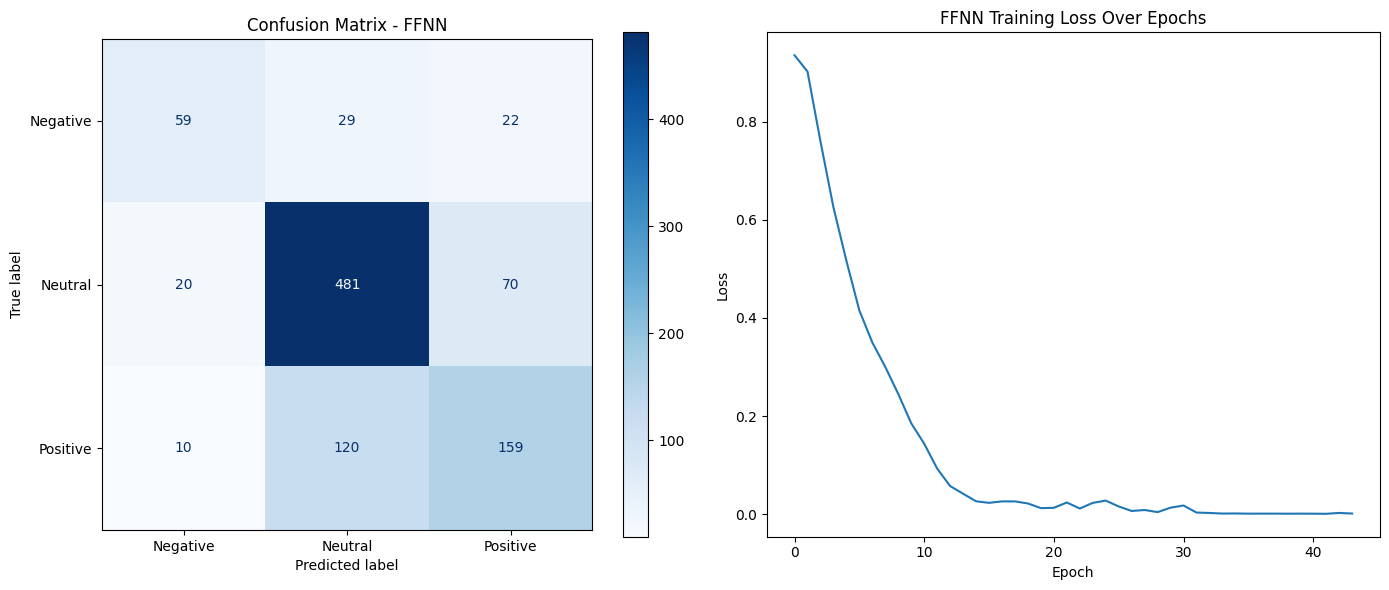

In [ ]:

# FFNN Evaluation: Test set predictions and metrics
ff_nn_model_4layer.eval()  # Set the model to evaluation mode
ffnn_predictions = []
actual_labels = []

with torch.no_grad():
    for i in range(len(X_test_bow)):
        bow_vector = X_test_bow[i].to(device)  # Move to GPU if available

        # Add an extra dimension to the input
        bow_vector = bow_vector.unsqueeze(0)  # Shape: (1, input_dim)

        output = ff_nn_model_4layer(bow_vector)

        # Get the predicted label
        predicted_label = torch.argmax(output, dim=1).item()
        ffnn_predictions.append(predicted_label)
        actual_labels.append(y_test[i].item())

# Accuracy, classification report, and confusion matrix
accuracy = accuracy_score(actual_labels, ffnn_predictions)
print(f"FFNN Accuracy: {accuracy:.4f}")

print("FFNN Classification Report:")
print(classification_report(actual_labels, ffnn_predictions, target_names=["Negative", "Neutral", "Positive"]))

# Confusion matrix
cm = confusion_matrix(actual_labels, ffnn_predictions)

# Create subplots for confusion matrix and loss plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title("Confusion Matrix - FFNN")

# Loss over epochs plot
axes[1].plot(ffnn_losses_4layer)  # Plot the 4-layer model losses
axes[1].set_title("FFNN Training Loss Over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


Naive Bayes Accuracy: 0.6031
Naive Bayes Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.03      0.05       110
     Class 1       0.62      0.93      0.74       571
     Class 2       0.47      0.18      0.26       289

    accuracy                           0.60       970
   macro avg       0.70      0.38      0.35       970
weighted avg       0.62      0.60      0.52       970



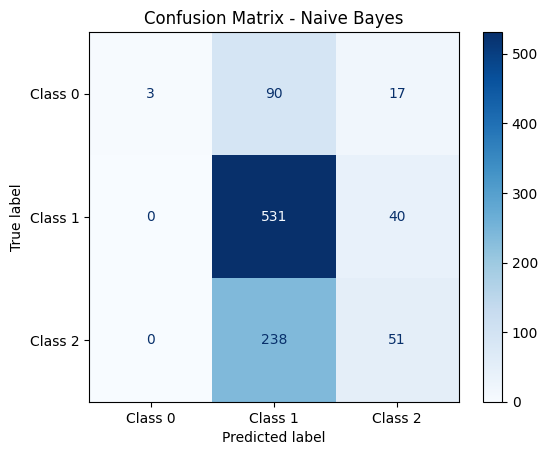

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Instantiate the Naive Bayes classifier
nb_model = GaussianNB()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bow.cpu().numpy())
X_test_scaled = scaler.transform(X_test_bow.cpu().numpy())

nb_model.fit(X_train_scaled, y_train.cpu().numpy())
nb_predictions = nb_model.predict(X_test_scaled)

# Predictions on the test set
nb_predictions = nb_model.predict(X_test_bow.cpu().numpy())

# Evaluation metrics
accuracy = accuracy_score(y_test.cpu().numpy(), nb_predictions)
print(f"Naive Bayes Accuracy: {accuracy:.4f}")

print("Naive Bayes Classification Report:")
print(classification_report(y_test.cpu().numpy(), nb_predictions, target_names=["Class 0", "Class 1", "Class 2"]))

# Confusion matrix
cm = confusion_matrix(y_test.cpu().numpy(), nb_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

Naive Bayes Accuracy: 0.7021
Naive Bayes Classification Report:
              precision    recall  f1-score   support

     Class 0       0.52      0.67      0.58       110
     Class 1       0.77      0.83      0.80       571
     Class 2       0.64      0.46      0.54       289

    accuracy                           0.70       970
   macro avg       0.64      0.65      0.64       970
weighted avg       0.70      0.70      0.70       970



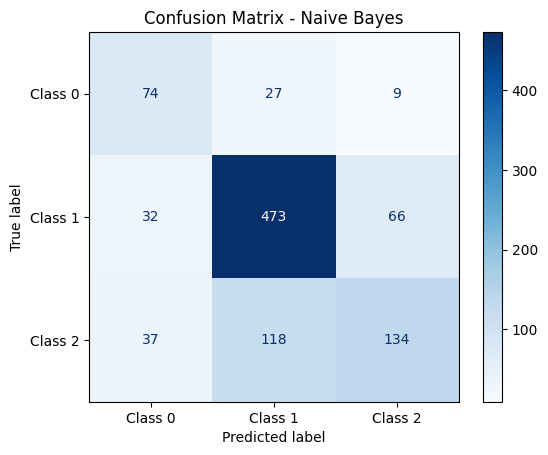

In [ ]:
from sklearn.naive_bayes import MultinomialNB


from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Instantiate the Naive Bayes classifier
nb_model = MultinomialNB()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bow.cpu().numpy())
X_test_scaled = scaler.transform(X_test_bow.cpu().numpy())

nb_model.fit(X_train_bow.cpu().numpy(), y_train.cpu().numpy())
nb_predictions = nb_model.predict(X_test_bow.cpu().numpy())

# Predictions on the test set
nb_predictions = nb_model.predict(X_test_bow.cpu().numpy())

# Evaluation metrics
accuracy = accuracy_score(y_test.cpu().numpy(), nb_predictions)
print(f"Naive Bayes Accuracy: {accuracy:.4f}")

print("Naive Bayes Classification Report:")
print(classification_report(y_test.cpu().numpy(), nb_predictions, target_names=["Class 0", "Class 1", "Class 2"]))

# Confusion matrix
cm = confusion_matrix(y_test.cpu().numpy(), nb_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Naive Bayes")
plt.show()


Naive Bayes Accuracy: 0.7021
Naive Bayes Classification Report:
              precision    recall  f1-score   support

     Class 0       0.52      0.67      0.58       110
     Class 1       0.77      0.83      0.80       571
     Class 2       0.64      0.46      0.54       289

    accuracy                           0.70       970
   macro avg       0.64      0.65      0.64       970
weighted avg       0.70      0.70      0.70       970



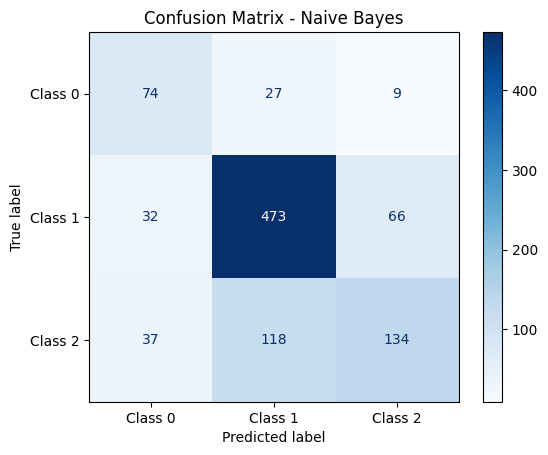

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_bow.cpu().numpy(), y_train.cpu().numpy())


from sklearn.naive_bayes import MultinomialNB


from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Instantiate the Naive Bayes classifier
nb_model = MultinomialNB()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bow.cpu().numpy())
X_test_scaled = scaler.transform(X_test_bow.cpu().numpy())

nb_model.fit(X_train_bow.cpu().numpy(), y_train.cpu().numpy())
nb_predictions = nb_model.predict(X_test_bow.cpu().numpy())

# Predictions on the test set
nb_predictions = nb_model.predict(X_test_bow.cpu().numpy())

# Evaluation metrics
accuracy = accuracy_score(y_test.cpu().numpy(), nb_predictions)
print(f"Naive Bayes Accuracy: {accuracy:.4f}")

print("Naive Bayes Classification Report:")
print(classification_report(y_test.cpu().numpy(), nb_predictions, target_names=["Class 0", "Class 1", "Class 2"]))

# Confusion matrix
cm = confusion_matrix(y_test.cpu().numpy(), nb_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Naive Bayes")
plt.show()


In [ ]:

# Define RNN model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last output of the RNN sequence
        return out


In [ ]:

# Define constants
input_dim = vocab_size  # Number of features
hidden_dim = 512 # Hidden layer size
output_dim = len(torch.unique(y_train))  # Number of classes
num_layers = 2
learning_rate = 1e-2
patience = 10
min_delta = 1e-3

# Instantiate the model
rnn_model = RNNModel(input_dim, hidden_dim, output_dim, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)

# Prepare DataLoader
train_dataset = TensorDataset(X_train_bow.unsqueeze(1), y_train)  # Add sequence dimension
train_loader = DataLoader(dataset=train_dataset, shuffle=True)

# Early stopping variables
best_loss = float("inf")
epochs_without_improvement = 0
epoch = 0
rnn_losses = []

# Training loop
while True:
    epoch += 1
    total_loss = 0
    rnn_model.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output = rnn_model(data)

        # Compute loss
        loss = criterion(output, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    rnn_losses.append(avg_loss)

    print(f"Epoch [{epoch}], Loss: {avg_loss:.4f}")

    # Early stopping check
    if avg_loss < best_loss - min_delta:
        best_loss = avg_loss
        epochs_without_improvement = 0  # Reset patience counter
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch} with best loss {best_loss:.4f}")
        break


Epoch [1], Loss: 3.5417
Epoch [2], Loss: 3.1396
Epoch [3], Loss: 2.8593
Epoch [4], Loss: 2.7735
Epoch [5], Loss: 2.4055
Epoch [6], Loss: 2.5582
Epoch [7], Loss: 2.0593
Epoch [8], Loss: 1.8758
Epoch [9], Loss: 1.7444
Epoch [10], Loss: 1.7324
Epoch [11], Loss: 1.3663
Epoch [12], Loss: 1.5439
Epoch [13], Loss: 1.4907
Epoch [14], Loss: 1.2299
Epoch [15], Loss: 0.9742
Epoch [16], Loss: 1.1122
Epoch [17], Loss: 0.9635
Epoch [18], Loss: 0.8545
Epoch [19], Loss: 0.8771
Epoch [20], Loss: 0.8341
Epoch [21], Loss: 0.7917
Epoch [22], Loss: 0.8924
Epoch [23], Loss: 0.8152
Epoch [24], Loss: 0.8011
Epoch [25], Loss: 0.8136
Epoch [26], Loss: 0.7491
Epoch [27], Loss: 0.5652
Epoch [28], Loss: 0.5734
Epoch [29], Loss: 0.6202
Epoch [30], Loss: 0.6865
Epoch [31], Loss: 0.5858
Epoch [32], Loss: 0.5798
Epoch [33], Loss: 0.5964
Epoch [34], Loss: 0.7054
Epoch [35], Loss: 0.6280
Epoch [36], Loss: 0.6737
Epoch [37], Loss: 0.5564
Epoch [38], Loss: 0.6711
Epoch [39], Loss: 0.5724
Epoch [40], Loss: 0.4910
Epoch [41

RNN Accuracy: 0.7361
RNN Classification Report:
              precision    recall  f1-score   support

     Class 0       0.61      0.62      0.61       110
     Class 1       0.76      0.89      0.82       571
     Class 2       0.72      0.48      0.58       289

    accuracy                           0.74       970
   macro avg       0.70      0.66      0.67       970
weighted avg       0.73      0.74      0.72       970



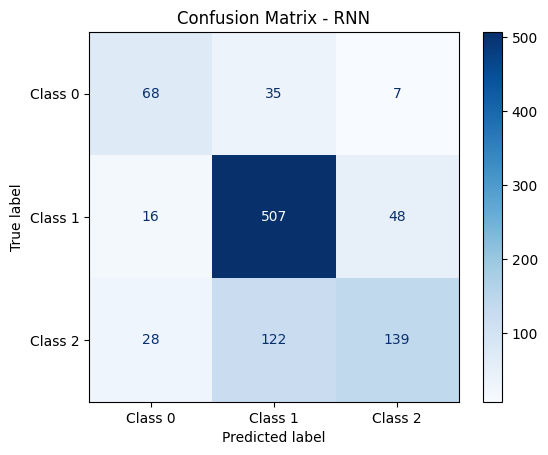

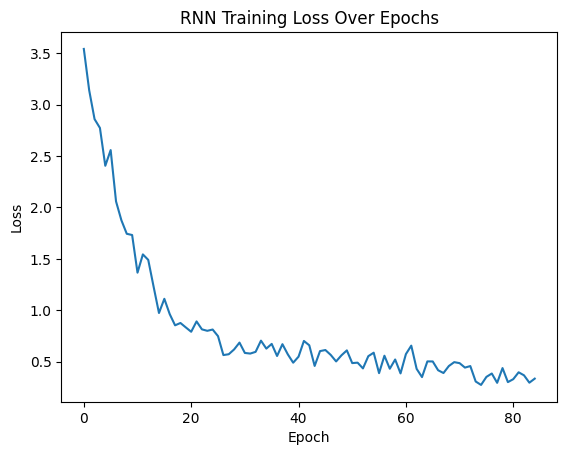

In [ ]:

# Evaluation on the test set
rnn_model.eval()
rnn_predictions = []
actual_labels = []

with torch.no_grad():
    for i in range(len(X_test_bow)):
        input_vector = X_test_bow[i].to(device).unsqueeze(0).unsqueeze(1)  # Shape: (1, 1, input_dim)
        output = rnn_model(input_vector)
        predicted_label = torch.argmax(output, dim=1).item()
        rnn_predictions.append(predicted_label)
        actual_labels.append(y_test[i].item())

# Metrics
accuracy = accuracy_score(actual_labels, rnn_predictions)
print(f"RNN Accuracy: {accuracy:.4f}")

print("RNN Classification Report:")
print(classification_report(actual_labels, rnn_predictions, target_names=["Class 0", "Class 1", "Class 2"]))

# Confusion matrix
cm = confusion_matrix(actual_labels, rnn_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - RNN")
plt.show()

# Loss plot
plt.plot(rnn_losses)
plt.title("RNN Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last output of the LSTM sequence
        return out

In [ ]:


# Define constants
input_dim = vocab_size  # Number of features
hidden_dim = 512  # LSTM hidden layer size
output_dim = 3
num_layers = 2
learning_rate = 1e-3
patience = 10
min_delta = 1e-3

# Instantiate the model
lstm_model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

# Prepare DataLoader
train_dataset = TensorDataset(X_train_bow.unsqueeze(1), y_train)  # Add sequence dimension
train_loader = DataLoader(dataset=train_dataset, shuffle=True)

# Early stopping variables
best_loss = float("inf")
epochs_without_improvement = 0
epoch = 0
lstm_losses = []

# Training loop
while True:
    epoch += 1
    total_loss = 0
    lstm_model.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output = lstm_model(data)

        # Compute loss
        loss = criterion(output, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    lstm_losses.append(avg_loss)

    print(f"Epoch [{epoch}], Loss: {avg_loss:.4f}")

    # Early stopping check
    if avg_loss < best_loss - min_delta:
        best_loss = avg_loss
        epochs_without_improvement = 0  # Reset patience counter
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch} with best loss {best_loss:.4f}")
        break


Epoch [1], Loss: 0.7362
Epoch [2], Loss: 0.3835
Epoch [3], Loss: 0.1981
Epoch [4], Loss: 0.0903
Epoch [5], Loss: 0.0494
Epoch [6], Loss: 0.0321
Epoch [7], Loss: 0.0191
Epoch [8], Loss: 0.0193
Epoch [9], Loss: 0.0153
Epoch [10], Loss: 0.0036
Epoch [11], Loss: 0.0093
Epoch [12], Loss: 0.0127
Epoch [13], Loss: 0.0051
Epoch [14], Loss: 0.0023
Epoch [15], Loss: 0.0020
Epoch [16], Loss: 0.0020
Epoch [17], Loss: 0.0019
Epoch [18], Loss: 0.0019
Epoch [19], Loss: 0.0019
Epoch [20], Loss: 0.0133
Epoch [21], Loss: 0.0023
Epoch [22], Loss: 0.0019
Epoch [23], Loss: 0.0019
Epoch [24], Loss: 0.0019
Early stopping at epoch 24 with best loss 0.0023


LSTM Accuracy: 0.7268
LSTM Classification Report:
              precision    recall  f1-score   support

     Class 0       0.64      0.58      0.61       110
     Class 1       0.78      0.83      0.80       571
     Class 2       0.64      0.58      0.61       289

    accuracy                           0.73       970
   macro avg       0.69      0.66      0.67       970
weighted avg       0.72      0.73      0.72       970



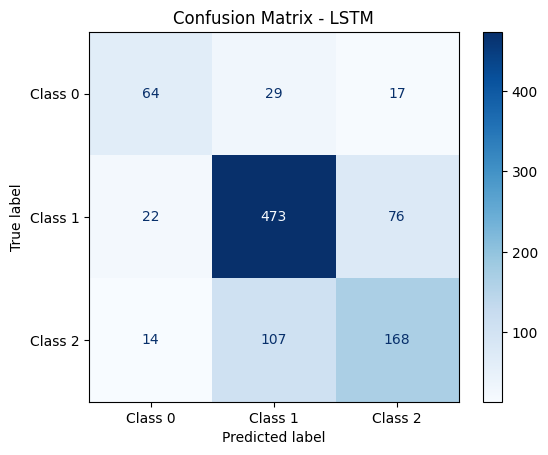

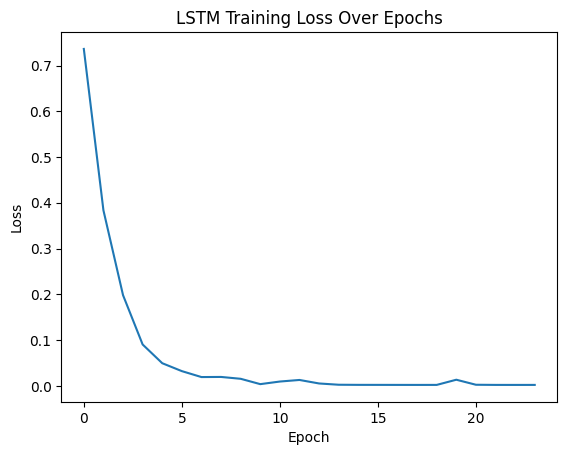

In [ ]:

# Evaluation on the test set
lstm_model.eval()
lstm_predictions = []
actual_labels = []

with torch.no_grad():
    for i in range(len(X_test_bow)):
        input_vector = X_test_bow[i].to(device).unsqueeze(0).unsqueeze(1)  # Shape: (1, 1, input_dim)
        output = lstm_model(input_vector)
        predicted_label = torch.argmax(output, dim=1).item()
        lstm_predictions.append(predicted_label)
        actual_labels.append(y_test[i].item())

# Metrics
accuracy = accuracy_score(actual_labels, lstm_predictions)
print(f"LSTM Accuracy: {accuracy:.4f}")

print("LSTM Classification Report:")
print(classification_report(actual_labels, lstm_predictions, target_names=["Class 0", "Class 1", "Class 2"]))

# Confusion matrix
cm = confusion_matrix(actual_labels, lstm_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - LSTM")
plt.show()

# Loss plot
plt.plot(lstm_losses)
plt.title("LSTM Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# Models to evaluate
models = {
    "Naive Bayes": nb_model,  # Assuming nb_model is your Naive Bayes model
    "FFNN 1 Layer": ff_nn_model_1layer,
    "FFNN 2 Layer": ff_nn_model_2layer,
    "FFNN 3 Layer": ff_nn_model_3layer,
    "FFNN 4 Layer": ff_nn_model_4layer,
    "RNN": rnn_model,
    "LSTM": lstm_model,
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

# Store results
results = {}

# Loop through each model
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    accuracies = []

    # For deep learning models, we need to predict differently
    is_deep_learning_model = model_name.startswith("FFNN") or model_name in ["RNN", "LSTM"]

    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_bow.cpu().numpy(), y_train.cpu().numpy())):
        X_train_fold, X_val_fold = X_train_bow[train_idx], X_train_bow[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        if is_deep_learning_model:
            # Deep learning models: predict using the model's forward method
            model.eval()
            with torch.no_grad():
                val_predictions = []
                for i in range(len(X_val_fold)):
                    input_vector = X_val_fold[i].to(device).unsqueeze(0)  # Adjust shape as needed for RNN/LSTM
                    if model_name in ["RNN", "LSTM"]:
                        input_vector = input_vector.unsqueeze(1)  # Add sequence dimension for RNN/LSTM
                    output = model(input_vector)
                    predicted_label = torch.argmax(output, dim=1).item()
                    val_predictions.append(predicted_label)

            accuracy = accuracy_score(y_val_fold.cpu().numpy(), val_predictions)

        else:
            # Scikit-learn models: predict directly
            X_train_fold_np = X_train_fold.cpu().numpy()
            X_val_fold_np = X_val_fold.cpu().numpy()
            if model_name == "Naive Bayes":  # Special handling for NB
                # Instead of StandardScaler, clip negative values to 0
                X_train_fold_np = np.clip(X_train_fold_np, 0, None)  # Clip negative values in training data
                X_val_fold_np = np.clip(X_val_fold_np, 0, None)    # Clip negative values in validation data

            model.fit(X_train_fold_np, y_train_fold.cpu().numpy())
            val_predictions = model.predict(X_val_fold_np)
            accuracy = accuracy_score(y_val_fold.cpu().numpy(), val_predictions)


        accuracies.append(accuracy)
        print(f"  Fold {fold + 1}: Accuracy = {accuracy:.4f}")

    results[model_name] = accuracies

# Print results
for model_name, accuracies in results.items():
    print(f"\n{model_name}:")
    print(f"  Accuracy: {np.mean(accuracies):.4f}")
    print(f"  Mean Cross-Validation Score: {np.mean(accuracies):.4f}")
    print(f"  Standard Deviation of Cross-Validation Scores: {np.std(accuracies):.4f}")
    from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
from prettytable import PrettyTable  # Import PrettyTable for tabular output

# ... (Your existing code for models, cross-validation, etc.) ...

# Create a PrettyTable object
table = PrettyTable()
table.field_names = ["Model", "Accuracy", "Mean CV Score", "Std Dev of CV Scores"]

# Print results in tabular format
for model_name, accuracies in results.items():
    table.add_row([
        model_name,
        f"{np.mean(accuracies):.4f}",  # Accuracy
        f"{np.mean(accuracies):.4f}",  # Mean CV Score
        f"{np.std(accuracies):.4f}",  # Std Dev of CV Scores
    ])

print(table)  # Print the table

Evaluating Naive Bayes...
  Fold 1: Accuracy = 0.6907
  Fold 2: Accuracy = 0.7268
  Fold 3: Accuracy = 0.6546
  Fold 4: Accuracy = 0.7268
  Fold 5: Accuracy = 0.6649
  Fold 6: Accuracy = 0.6856
  Fold 7: Accuracy = 0.6392
  Fold 8: Accuracy = 0.7216
  Fold 9: Accuracy = 0.7371
  Fold 10: Accuracy = 0.7835
  Fold 11: Accuracy = 0.6649
  Fold 12: Accuracy = 0.6959
  Fold 13: Accuracy = 0.6546
  Fold 14: Accuracy = 0.7062
  Fold 15: Accuracy = 0.6289
  Fold 16: Accuracy = 0.5979
  Fold 17: Accuracy = 0.6891
  Fold 18: Accuracy = 0.7047
  Fold 19: Accuracy = 0.7047
  Fold 20: Accuracy = 0.6736
Evaluating FFNN 1 Layer...
  Fold 1: Accuracy = 1.0000
  Fold 2: Accuracy = 1.0000
  Fold 3: Accuracy = 1.0000
  Fold 4: Accuracy = 1.0000
  Fold 5: Accuracy = 1.0000
  Fold 6: Accuracy = 1.0000
  Fold 7: Accuracy = 0.9897
  Fold 8: Accuracy = 1.0000
  Fold 9: Accuracy = 1.0000
  Fold 10: Accuracy = 1.0000
  Fold 11: Accuracy = 1.0000
  Fold 12: Accuracy = 1.0000
  Fold 13: Accuracy = 1.0000
  Fold 1

In [ ]:

def predict_sentiment(text):
    # Preprocess the input text (clean, tokenize, etc.)
    cleaned_text = clean_text(text)  # Assuming you have a 'clean_text' function
    tokens = cleaned_text.split()

    # Create BOW vector using word_to_ix from your training data
    bow_vector = make_bow_vector(tokens, word_to_ix)

    # Convert to PyTorch tensor and move to device (if using GPU)
    bow_vector = bow_vector.unsqueeze(0).to(device)

    # Make prediction
    ff_nn_model_2layer.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = ff_nn_model_3layer(bow_vector)
        predicted_label_index = torch.argmax(output, dim=1).item()

    # Map predicted label index back to sentiment label
    sentiment_labels = ['negative', 'neutral', 'positive']
    predicted_sentiment = sentiment_labels[predicted_label_index]

    return predicted_sentiment

# Create Gradio interface
iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=2, placeholder="Enter text here..."),
    outputs="text",
    title="Sentiment Analysis with FFNN 3 Layer Model",
    description="Enter text and get the predicted sentiment (negative, neutral, or positive)."
)

# Launch the interface
iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3671253fd3b6572200.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
